# Install Necessary Library


In [1]:
!pip install tensorflow==2.10
!pip install deepctr[cpu]
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download praneshmukhopadhyay/amazon-questionanswer-dataset
!unzip /content/amazon-questionanswer-dataset.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.2/141.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.10.0 which is incompatible.
Dataset URL: https://www.kaggle.com/datasets/praneshmukhopadhyay/amazon-questionanswer-dataset
License(s): CC0-1.0
 99% 423M/426M [00:03<00:00, 125MB/s]
100% 426M/426M [00:03<00:00, 121MB/s]
Archive:  /content/amazon-questionanswer-dataset.zip
  inflating: multi_answers.csv       
  inflating: multi_questions.csv     
  inflating: single_qna.csv          


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score , mean_squared_error

from itertools import chain

import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Concatenate ,Flatten ,Lambda

from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.feature_column import build_input_features, get_linear_logit, DEFAULT_GROUP_NAME, input_from_feature_columns
from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.interaction import FM ,InteractingLayer
from deepctr.layers.utils import concat_func, add_func, combined_dnn_input

from deepctr.feature_column import build_input_features, get_linear_logit, input_from_feature_columns ,VarLenSparseFeat

from deepctr.layers.core import PredictionLayer, DNN ,RegulationModule
from deepctr.layers.interaction import CrossNet ,BridgeModule
from deepctr.layers.utils import add_func, combined_dnn_input


In [4]:
data = pd.read_csv("multi_answers.csv")
data=data.dropna()
data

,QuestionID,AnswerText,AnswererID,AnswerTime,AnswerType,AnswerScore
2,C1Q1,"It's been a while since I installed them, but ...",A3BWPG98KF0TAV,"July 19, 2013",?,0.5428
3,C1Q1,1 pair rear flaps and mounting hardware.,1,"July 19, 2013",?,0.5565
4,C1Q1,I didn't buy these for myself I bought them fo...,A1MGZTOLD2C0VS,"July 19, 2013",?,0.4623
5,C1Q1,no,A1GU54G5GCLOGV,"July 20, 2013",N,0.0366
6,C1Q1,"Not sure, maybe measuring width of wheels and ...",A2FQI9PZSTWQTO,"July 19, 2013",?,0.1260
...,...,...,...,...,...,...
4019732,C17Q1183,To be honest idk srry,A24GF8XJ81UJCM,"March 24, 2015",?,0.5820
4019733,C17Q1183,Yes it should work and to completely honest do...,A3HVTKFMKZD9U8,"March 24, 2015",Y,0.9774
4019734,C17Q1183,http://www.systemrequirementslab.com/cyri/requ...,A215AZEU7D23KI,"March 25, 2015",?,0.6033
4019742,C17Q1183,Yes you can. I personally download from spinti...,A215AZEU7D23KI,"January 10, 2015",Y,0.9897


In [5]:
sparse_features = ["QuestionID", "AnswererID",
                    "AnswerTime", "AnswerType"]
target = ['AnswerScore']

for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
fixlen_feature_columns = [SparseFeat(feat, data[feat].max() + 1, embedding_dim=4)
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}


# Deep and Cross Network


In [6]:
def DCN(linear_feature_columns, dnn_feature_columns, cross_num=2, cross_parameterization='vector',
        dnn_hidden_units=(256, 128, 64), l2_reg_linear=1e-5, l2_reg_embedding=1e-5,
        l2_reg_cross=1e-5, l2_reg_dnn=0, seed=1024, dnn_dropout=0, dnn_use_bn=False,
        dnn_activation='relu', task='regression'):

    if len(dnn_hidden_units) == 0 and cross_num == 0:
        raise ValueError("Either hidden_layer or cross layer must > 0")

    features = build_input_features(dnn_feature_columns)
    inputs_list = list(features.values())

    linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
                                    l2_reg=l2_reg_linear)

    sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
                                                                         l2_reg_embedding, seed)

    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)

    if len(dnn_hidden_units) > 0 and cross_num > 0:  # Deep & Cross
        deep_out = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
        cross_out = CrossNet(cross_num, parameterization=cross_parameterization, l2_reg=l2_reg_cross)(dnn_input)
        stack_out = Concatenate()([cross_out, deep_out])
        final_logit = Dense(1, use_bias=False)(stack_out)
    elif len(dnn_hidden_units) > 0:  # Only Deep
        deep_out = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
        final_logit = Dense(1, use_bias=False)(deep_out)
    elif cross_num > 0:  # Only Cross
        cross_out = CrossNet(cross_num, parameterization=cross_parameterization, l2_reg=l2_reg_cross)(dnn_input)
        final_logit = Dense(1, use_bias=False)(cross_out)
    else:  # Error
        raise NotImplementedError

    final_logit = add_func([final_logit, linear_logit])
    output = PredictionLayer(task)(final_logit)

    model = Model(inputs=inputs_list, outputs=output)

    return model

In [7]:
model = DCN(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse", metrics=['mse'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(
    test[target].values, pred_ans), 4))

CrossNet parameterization: vector
Epoch 1/10
1502/1502 - 72s - loss: 0.0399 - mse: 0.0378 - val_loss: 0.0373 - val_mse: 0.0329
Epoch 2/10
1502/1502 - 55s - loss: 0.0140 - mse: 0.0098 - val_loss: 0.0401 - val_mse: 0.0353
Epoch 3/10
1502/1502 - 64s - loss: 0.0227 - mse: 0.0157 - val_loss: 0.0454 - val_mse: 0.0364
Epoch 4/10
1502/1502 - 53s - loss: 0.0178 - mse: 0.0095 - val_loss: 0.0519 - val_mse: 0.0440
Epoch 5/10
1502/1502 - 54s - loss: 0.0148 - mse: 0.0076 - val_loss: 0.0438 - val_mse: 0.0369
Epoch 6/10
1502/1502 - 63s - loss: 0.0137 - mse: 0.0072 - val_loss: 0.0417 - val_mse: 0.0353
Epoch 7/10
1502/1502 - 56s - loss: 0.0138 - mse: 0.0076 - val_loss: 0.0424 - val_mse: 0.0361
Epoch 8/10
1502/1502 - 55s - loss: 0.0147 - mse: 0.0086 - val_loss: 0.0449 - val_mse: 0.0384
Epoch 9/10
1502/1502 - 55s - loss: 0.0150 - mse: 0.0088 - val_loss: 0.0475 - val_mse: 0.0410
Epoch 10/10
1502/1502 - 63s - loss: 0.0150 - mse: 0.0088 - val_loss: 0.0503 - val_mse: 0.0437
test MSE 0.0437


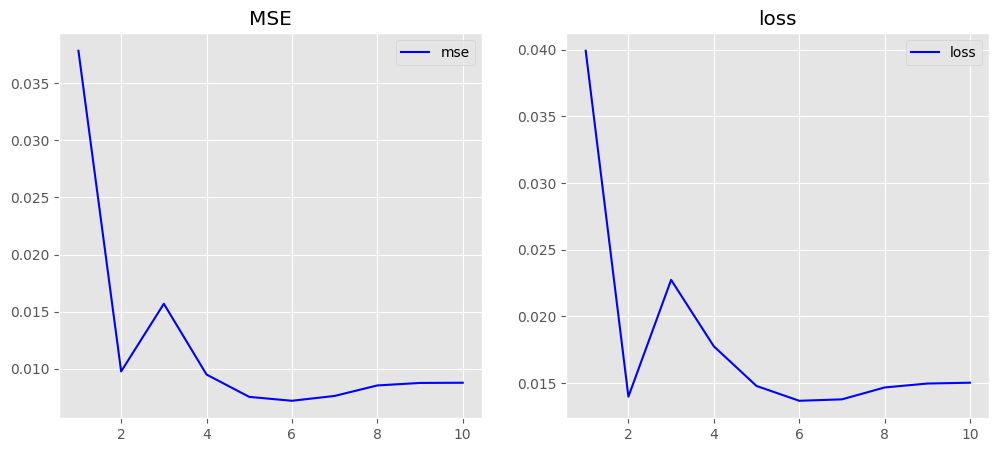

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    mse = history.history['mse']
    loss = history.history['loss']
    x = range(1, len(mse) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, mse, 'b', label='mse')
    plt.title('MSE')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='loss')
    plt.title('loss')
    plt.legend()

plot_history(history)

In [11]:
def DIFM(linear_feature_columns, dnn_feature_columns,
         att_embedding_size=8, att_head_num=8, att_res=True, dnn_hidden_units=(256, 128, 64),
         l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, seed=1024, dnn_dropout=0,
         dnn_activation='relu', dnn_use_bn=False, task='regression'):


    if not len(dnn_hidden_units) > 0:
        raise ValueError("dnn_hidden_units is null!")

    features = build_input_features(
        linear_feature_columns + dnn_feature_columns)

    sparse_feat_num = len(list(filter(lambda x: isinstance(x, SparseFeat) or isinstance(x, VarLenSparseFeat),
                                      dnn_feature_columns)))
    inputs_list = list(features.values())

    sparse_embedding_list, _ = input_from_feature_columns(features, dnn_feature_columns,
                                                          l2_reg_embedding, seed)

    if not len(sparse_embedding_list) > 0:
        raise ValueError("there are no sparse features")

    att_input = concat_func(sparse_embedding_list, axis=1)
    att_out = InteractingLayer(att_embedding_size, att_head_num, att_res, scaling=True)(att_input)
    att_out = Flatten()(att_out)
    m_vec = Dense(sparse_feat_num, use_bias=False)(att_out)

    dnn_input = combined_dnn_input(sparse_embedding_list, [])
    dnn_output = DNN(dnn_hidden_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
    m_bit = Dense(sparse_feat_num, use_bias=False)(dnn_output)

    input_aware_factor = add_func([m_vec, m_bit])  # the complete input-aware factor m_x

    linear_logit = get_linear_logit(features, linear_feature_columns, seed=seed, prefix='linear',
                                    l2_reg=l2_reg_linear, sparse_feat_refine_weight=input_aware_factor)

    fm_input = concat_func(sparse_embedding_list, axis=1)
    refined_fm_input = Lambda(lambda x: x[0] * tf.expand_dims(x[1], axis=-1))(
        [fm_input, input_aware_factor])
    fm_logit = FM()(refined_fm_input)

    final_logit = add_func([linear_logit, fm_logit])

    output = PredictionLayer(task)(final_logit)
    model = Model(inputs=inputs_list, outputs=output)
    return model

In [12]:
model = DIFM(linear_feature_columns, dnn_feature_columns, task='regression')
model.compile("adam", "mse",
              metrics=['accuracy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(
    test[target].values, pred_ans), 4))

Epoch 1/10
1502/1502 - 82s - loss: 0.0469 - accuracy: 2.6010e-06 - val_loss: 0.0371 - val_accuracy: 1.0404e-05
Epoch 2/10
1502/1502 - 71s - loss: 0.0135 - accuracy: 2.6010e-06 - val_loss: 0.0392 - val_accuracy: 1.0404e-05
Epoch 3/10
1502/1502 - 76s - loss: 0.0158 - accuracy: 2.6010e-06 - val_loss: 0.0425 - val_accuracy: 1.0404e-05
Epoch 4/10
1502/1502 - 66s - loss: 0.0147 - accuracy: 2.6010e-06 - val_loss: 0.0473 - val_accuracy: 1.0404e-05
Epoch 5/10
1502/1502 - 77s - loss: 0.0147 - accuracy: 2.6010e-06 - val_loss: 0.0417 - val_accuracy: 1.0404e-05
Epoch 6/10
1502/1502 - 82s - loss: 0.0130 - accuracy: 2.6010e-06 - val_loss: 0.0415 - val_accuracy: 1.0404e-05
Epoch 7/10
1502/1502 - 68s - loss: 0.0133 - accuracy: 2.6010e-06 - val_loss: 0.0422 - val_accuracy: 1.0404e-05
Epoch 8/10
1502/1502 - 72s - loss: 0.0138 - accuracy: 2.6010e-06 - val_loss: 0.0416 - val_accuracy: 1.0404e-05
Epoch 9/10
1502/1502 - 64s - loss: 0.0131 - accuracy: 2.6010e-06 - val_loss: 0.0415 - val_accuracy: 1.0404e-05
E